In [1]:
import IPython
import pandas as pd
import keras
import itertools
import numpy as np
import matplotlib.pyplot as plt
import ModelStorage

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, TimeDistributed, Activation
from keras.layers import LSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from kerasify import export_model
from keras.models import model_from_json
import os

Using TensorFlow backend.


In [2]:
def RunNetwork(epo,dropout,networknum,class_name,Xvector,valpercent,timestep,iteration,dataInfo):
    timesteps = timestep
    ## POSE - val_acc: 98%
    epochs = epo
    batch_size = 32
    _dropout = dropout
    _activation = 'relu'
    _optimizer = 'Adam'
    class_names = class_name  # 4 classes
    X_vector_dim = Xvector  # number of features or columns (pose)
    samples_path = "data20.txt"  # 311 files with 10 frames' human-pose estimation keypoints(10*18)
    labels_path = "label.txt"  # 311 files' labels, 3 classes in total
    if os.path.isdir(str(iteration)) == True:
        pass
    else:
        os.makedirs(str(iteration))
    model_path = str(iteration)+'/20190419_class2_frame20.model'
    json_model_path = str(iteration)+'/20190419_class2_frame20.json'
    model_weights_path = str(iteration)+'/20190419_class2_frame20.h5'

    X = np.loadtxt(samples_path, dtype="float")
    y = np.loadtxt(labels_path)

    def samples_to_3D_array(_vector_dim, _vectors_per_sample, _X):
        X_len = len(_X)
        result_array = []
        for sample in range(0, X_len):  # should be the 311 samples?
            sample_array = []
            for vector_idx in range(0, _vectors_per_sample):
                start = vector_idx * _vector_dim
                end = start + _vector_dim
                sample_array.append(_X[sample][start:end])
            result_array.append(sample_array)
        return np.asarray(result_array)

    X_vectors_per_sample = timesteps  # number of vectors per sample , 5 samples
    X_3D = samples_to_3D_array(X_vector_dim, X_vectors_per_sample, X)

    def convert_y_to_one_hot(_y):  # one hot encoding simply means : red --> 0 , green --> 1 , blue --> 2
        _y = np.asarray(_y, dtype=int)
        b = np.zeros((_y.size, _y.max() + 1))
        b[np.arange(_y.size), _y] = 1
        return b

    y_one_hot = convert_y_to_one_hot(y)
    y_vector_dim = y_one_hot.shape[1]

    X_train, X_test, y_train, y_test = train_test_split(X_3D, y_one_hot, test_size=valpercent, random_state=42)
    input_shape = (X_train.shape[1], X_train.shape[2])

    #model = Sequential()
    #model.add(TimeDistributed(Dense(X_vector_dim, activation=_activation), input_shape=input_shape))
    #model.add(Dropout(_dropout))
    #model.add(TimeDistributed(Dense(X_vector_dim * 2, activation=_activation)))  # (5, 80)
    #model.add(Dropout(_dropout))
    #model.add(TimeDistributed(Dense(X_vector_dim, activation=_activation)))  # (5, 40)
    #model.add(Dropout(_dropout))
    #model.add(TimeDistributed(Dense(int(X_vector_dim / 2), activation=_activation)))  # (5, 20)
    #model.add(Dropout(_dropout))
    #model.add(TimeDistributed(Dense(int(X_vector_dim / 4), activation=_activation)))  # (5, 10)
    #model.add(Dropout(_dropout))
    #model.add(LSTM(int(X_vector_dim / 4), dropout=_dropout, recurrent_dropout=_dropout))
    #model.add(Dense(y_vector_dim, activation='softmax'))
    #NetworkInfo='*2_*1_/2_/4'
    model,NetworkInfo=ModelStorage.GetModel(networknum,_dropout,X_vector_dim,_activation,input_shape,y_vector_dim)
    model.compile(loss='categorical_crossentropy', optimizer=_optimizer, metrics=['accuracy'])

    class TrainingVisualizer(keras.callbacks.History):
        def on_epoch_end(self, epoch, logs={}):
            super(TrainingVisualizer, self).on_epoch_end(epoch, logs)
            IPython.display.clear_output(wait=True)
        #生成TrainingVisualizer图片
            if epoch == epochs - 1: 
                axes = pd.DataFrame(self.history).plot()
                axes.axvline(x=max((val_acc, i) for i, val_acc in enumerate(self.history['val_acc']))[1])
      

    print('Training...')
    model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_test, y_test),
              callbacks=[TrainingVisualizer()])

    score, accuracy = model.evaluate(X_test, y_test,
                                     batch_size=batch_size)
    
        
    doc = open('result.txt', 'a')
    print(iteration,file=doc)
    print('Test score: {:.3}'.format(score), file=doc)
    print('Test accuracy: {:.3}'.format(accuracy), file=doc)
    doc.close()

    y_pred = model.predict(X_test)

    def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):

        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        if os.path.isdir("graph/Confusion_Matrix") == True:
            pass
        else:
            os.makedirs("graph/Confusion_Matrix")
        plt.savefig('graph/Confusion_Matrix/CM_'+str(iteration))
        plt.close()

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
    np.set_printoptions(precision=2)
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # plt.show()
    if os.path.isdir("graph/TrainingVisualizer") == True:
        pass
    else:
        os.makedirs("graph/TrainingVisualizer")
    plt.savefig('graph/TrainingVisualizer/TV_'+str(iteration))

    export_model(model, model_path)
    print("Model saved to disk")

    model_json = model.to_json()
    with open(json_model_path, "w") as json_file:
        json_file.write(json_model_path)
    # serialize weights to HDF5
    model.save_weights(model_weights_path)
    model.save('20190419_class3_frame20.h5')
    print("Saved model to disk")
    
    docdes = open('description.txt', 'a')
    docdes.write(str(iteration)+"\n")
    docdes.write("Data source: "+dataInfo+"\n")
    docdes.write("Network: "+NetworkInfo+"\n")
    docdes.write("epochs: "+str(epo)+"\n")
    docdes.write("dropout: "+str(dropout)+"\n")
    docdes.write("Validation percentage: "+str(valpercent)+"\n")
    docdes.write('\n')
    docdes.close

In [3]:
def TrainMulModel(epochs,dropout,networknum,Xvector,class_name,valpercent,timestep,dataInfo,iteration):
    for i in epochs:
        for j in dropout:
            for k in range(networknum):
                for m in valpercent:
                    
                #print(i,j,k,class_name,Xvector,valpercent,timestep,iteration,dataInfo)
                    RunNetwork(i,j,k,class_name,Xvector,m,timestep,iteration,dataInfo)
                    iteration=iteration+1

In [6]:
def GetInput():
    rawepochs=input("Please input the epochs:")
    epols = rawepochs.split(",")
    epo =[ int(x) for x in epols ]
    rawdropout=input("Please input the dropouts:")
    dropls = rawdropout.split(",")
    drop =[ float(x) for x in dropls ]
    networknum=eval(input("Please input the network number:"))
    X_vector_dim=eval(input("Please input the X_vector_dim:"))
    infofile=open('information.txt')
    info=infofile.readlines()
    dataInfo=info[1]
    classinfo=info[0]
    class_name=classinfo.split(",")
    infofile.close()
    rawval=input("Please input the percentage of validation:")
    valls = rawval.split(",")
    valpercent =[ float(x) for x in valls ]
    timestep=input("Please input the timestep:")
    num=eval(input("begin with: "))
    return epo,drop,networknum,X_vector_dim,class_name,valpercent,int(timestep),dataInfo,num

In [7]:
Epoch,DropOut,NetNum,XVector,ClassName,ValPercent,TimeStep,DataInformation,Number=GetInput()

Please input the epochs:200
Please input the dropouts:0.25
Please input the network number:1
Please input the X_vector_dim:18
Please input the percentage of validation:0.25
Please input the timestep:20
begin with: 1


11917/11917 [==============================] - 6s 518us/step
Confusion matrix, without normalization
[[4677  219  138]
 [  35 2076  129]
 [ 119  491 4033]]
Model saved to disk
Saved model to disk


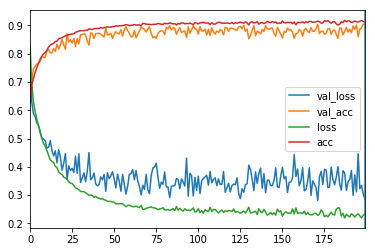

In [8]:
TrainMulModel(Epoch,DropOut,NetNum,XVector,ClassName,ValPercent,TimeStep,DataInformation,Number)

In [ ]:
print(Epoch)
print(DropOut)
print(NetNum)
print(XVector)
print(ClassName)
print(ValPercent)
print(TimeStep)
print(DataInformation)
print()

62/62 [==============================] - 0s 644us/step
Confusion matrix, without normalization
[[ 0 17  0  0]
 [ 0 13  0  0]
 [ 0 18  0  0]
 [ 0 14  0  0]]
Model saved to disk
Saved model to disk


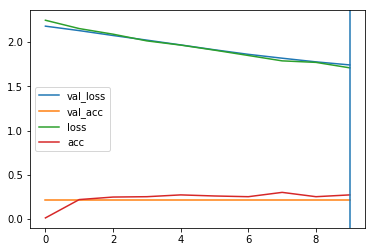

In [11]:
RunNetwork(10,0.1,3,['FRight', 'FWrong', 'SRight', 'SWrongHand'],36,0.2,15,3,"all W, 0213, nowait")

In [79]:
info=open('class_name.txt')

In [80]:
Ins=info.readlines()

In [81]:
Ins

['FRight,FWrong,SRight,SWrongHand\n', 'all W, 0213, nowait']

In [5]:
f=open('information.txt')

In [6]:
line=f.readlines()

In [8]:
line[1]

'all W, 0213, nowait'

In [13]:
line

['FRight,FWrong,SRight,SWrongHand\n', 'all W, 0213, nowait']

In [75]:
import ModelStorage

In [77]:
model,des=ModelStorage.GetModel(0,0.1,36,'relu',(36,15),5)

In [79]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_11 (TimeDis (None, 36, 36)            576       
_________________________________________________________________
dropout_11 (Dropout)         (None, 36, 36)            0         
_________________________________________________________________
time_distributed_12 (TimeDis (None, 36, 72)            2664      
_________________________________________________________________
dropout_12 (Dropout)         (None, 36, 72)            0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 36, 36)            2628      
_________________________________________________________________
dropout_13 (Dropout)         (None, 36, 36)            0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, 36, 18)            666       
__________